# Reconstructing a Sim-Ready Scene from a 3D Capture using 3D Gaussian Splatting
----
In this notebook, we'll walk through how to reconstruct a Gaussian Splat radiance field from an input 3d capture. The capture consists of a collection of posed images along with sparse points.  We'll also show how you can visualize this radiance field interactively in a notebook or browser, how to save the radiance field to common formats like PLY and USDZ, and how to use the radiance field to construct a high quality triangle mesh. Along the way, we'll get a tour of the basic components of the `fvdb_reality_capture` library.

In [1]:
import logging

import cv2
import fvdb
import matplotlib.pyplot as plt
import numpy as np
import torch

import fvdb_reality_capture as frc
import fvdb_reality_capture.transforms as frctx

# Let's use verbose logging to track what happens under the hood.
# For less output set level=logging.WARN. For more set level=logging.DEBUG
logging.basicConfig(level=logging.INFO, format="%(levelname)s : %(message)s")

## Download some example data
First, let's download some example data to run on. These datasets are the output of a COLMAP SfM pipeline on a sequence of images.
They contain images, camera poses (camera to world transformations), camera projection parameters, and a set of sparse 3D points at known surfaces in the scene.

In [2]:
# Download example data for running splats on
frc.tools.download_example_data(dataset="safety_park", download_path="./data")

2025-10-14 15:48:34,167 - fvdb_reality_capture.tools._download_example_data.download_example_data - WARNING - Dataset directory data/safety_park already exists. Skipping download.


## Load and preprocess data for reconstruction

At its core, `fvdb_reality_capture` is a library of operators which operate on 3D captures which generally consist of:
 1. Posed images. _i.e._ Images with a world-to-camera transformation specifying from where each image was taken in the scene, and the parameters of the camera that captured them.
 2. Scanned 3D points which lie on surfaces captured from the scene.
 3. A mapping between images and points specifying which points were seen by which images.

This type of data may arise from capture hardware (_e.g._ a set of cameras and LiDAR sensors equipped with [Inertial Measurement Units (IMU)](https://en.wikipedia.org/wiki/Inertial_measurement_unit) sensors), or [from Structure-from-Motion (Sfm)](https://en.wikipedia.org/wiki/Structure_from_motion) capture which solves for camera poses and points using correspondences between a set of images.

`fvdb_reality_capture` aims to support loading in capture data stored in different formats into a common representation that can be easily manipulated by users.

To do this, data from a cature is stored in an `fvdb_reality_capture.SfmScene` object which acts as an in memory representation of a 3D capture. For an in-depth tutorial on manipulating data in an `SfmScene`, see the data_manipulation notebook.

In order to reconstruct a radiance field from captured, data we first load it into an `SfmScene`. Let's do this and plot some of the images with their visible scanned points.

2025-10-14 15:48:34,682 - fvdb_reality_capture.sfm_scene._load_colmap_scene.load_colmap_scene - INFO - Loading visible points per image from cache...


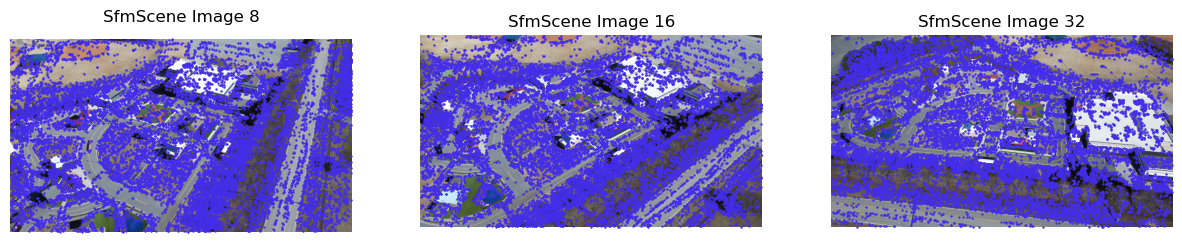

In [3]:
dataset_path = "./data/safety_park"
sfm_scene = frc.SfmScene.from_colmap(dataset_path)

# Visualize an image in an SfmScene and the 3D points visible from that images
# projected onto the image plane as blue dots.
def plot_image_from_scene(scene: frc.SfmScene, image_id: int):
    image_meta: frc.SfmImageMetadata = scene.images[image_id]
    camera_meta: frc.SfmCameraMetadata = image_meta.camera_metadata

    # Get the visible 3d points for this image
    visible_points_3d: np.ndarray = scene.points[image_meta.point_indices]

    # Project those points onto the image plane
    # 1. Get the world -> camera space transform and projection matrix
    world_to_cam_matrix: np.ndarray = image_meta.world_to_camera_matrix
    projection_matrix: np.ndarray = camera_meta.projection_matrix
    # 2. Transform world points to camera space
    visible_points_3d_cam_space = world_to_cam_matrix[:3,:3] @ visible_points_3d.T + world_to_cam_matrix[:3,3:4]
    # 3. Transform camera space coordinates to image space
    visible_points_2d = projection_matrix @ visible_points_3d_cam_space
    visible_points_2d /= visible_points_2d[2]

    # Load the image and convert to RGB (OpenCV uses BGR by default)
    loaded_image = cv2.imread(image_meta.image_path)
    assert loaded_image is not None, f"Failed to load image at {image_meta.image_path}"
    loaded_image = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2RGB)

    # Plot the image and projected points
    plt.title(f"SfmScene Image {image_id}")
    plt.axis("off")
    plt.imshow(loaded_image)
    plt.scatter(visible_points_2d[0], visible_points_2d[1], color="#432de9", marker=".", s=2)

# Plot three images and points alongside each other
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plot_image_from_scene(sfm_scene, 8)
plt.subplot(1, 3, 2)
plot_image_from_scene(sfm_scene, 16)
plt.subplot(1, 3, 3)
plot_image_from_scene(sfm_scene, 32)
plt.show()

Here we see three images from our input scene with the sparse points overlaid on the images. Before we reconstruct this scene using Gaussian Splatting, let's preprocess it a bit to clean it up and make the reconstruction process faster.

In this step, we'll do four preprocessing steps:
 1. Downsample the images by a factor of 4 to speed up Gaussian Splat optimization (loading big images can be time consuming), 
 2. Normalize the scene to a canonical coordinte space (using PCA)
 3. Remove outlier points below the bottom 3rd and top 97th percentiles along the X, Y, and Z, axis.
 4. Remove any images with fewer than 50 points (these images are likely to have bad pose estimates)

In [4]:
cleanup_and_resize_transform = frctx.Compose(
    frctx.DownsampleImages(image_downsample_factor=4, image_type="jpg", rescaled_jpeg_quality=95),
    frctx.NormalizeScene(normalization_type="pca"),
    frctx.PercentileFilterPoints(percentile_min=3.0, percentile_max=97.0)
)
cleaned_sfm_scene = cleanup_and_resize_transform(sfm_scene)

print(f"Original scene had {len(sfm_scene.points)} points and {len(sfm_scene.images)} images")
print(f"Cleaned scene has {len(cleaned_sfm_scene.points)} points and {len(cleaned_sfm_scene.images)} images")

2025-10-14 15:48:35,652 - fvdb_reality_capture.transforms.downsample_images.DownsampleImages - INFO - Rescaling images using downsample factor 4, sampling mode 3, and quality 95.
2025-10-14 15:48:35,652 - fvdb_reality_capture.transforms.downsample_images.DownsampleImages - INFO - Attempting to load downsampled images from cache.
2025-10-14 15:48:35,682 - fvdb_reality_capture.transforms.normalize_scene.NormalizeScene - INFO - Normalizing SfmScene with normalization type: pca
2025-10-14 15:48:35,693 - fvdb_reality_capture.transforms.percentile_filter_points.PercentileFilterPoints - INFO - Filtering points based on percentiles: min=[3. 3. 3.], max=[97. 97. 97.]


Original scene had 199702 points and 124 images
Cleaned scene has 168661 points and 124 images


`fvdb_reality_capture` makes processing `SfmScene`s easy via the use of the `fvdb_reality_capture.transforms` module, which exposes a set of composable transforms which can be applied to a scene. The transforms automatically cache their results. This means expensive operations (such as downsampling all the images in a dataset) are transparently cached and only happen once. Note how it took some time to clean up the scene. If we run the process again, it's almost instantaneous due to caching.

In [5]:
%time cleaned_sfm_scene = cleanup_and_resize_transform(sfm_scene)

2025-10-14 15:48:35,851 - fvdb_reality_capture.transforms.downsample_images.DownsampleImages - INFO - Rescaling images using downsample factor 4, sampling mode 3, and quality 95.
2025-10-14 15:48:35,852 - fvdb_reality_capture.transforms.downsample_images.DownsampleImages - INFO - Attempting to load downsampled images from cache.
2025-10-14 15:48:35,882 - fvdb_reality_capture.transforms.normalize_scene.NormalizeScene - INFO - Normalizing SfmScene with normalization type: pca
2025-10-14 15:48:35,885 - fvdb_reality_capture.transforms.percentile_filter_points.PercentileFilterPoints - INFO - Filtering points based on percentiles: min=[3. 3. 3.], max=[97. 97. 97.]


CPU times: user 460 ms, sys: 16 ms, total: 476 ms
Wall time: 175 ms


## Reconstruct a Gaussian splat radiance field

A [radiance field](https://radiancefields.com/) is a 3D scene representation that specifies the color of a point along a given view direction. Radiance fields enable high fidelity visualization of 3D captures with realistic lighting effects.

The dominant representation for radiance fields is 3D Gaussian Splatting<sup>[1](#references)</sup>, which encodes the radiance field function as a sum of Gaussians. 3D Gaussians are parameterized by their means (positions), rotations, and scales. Additionally each Gaussian has an opacity value and a set of spherical harmonics that map the direction in which a Gaussian is viewed to a color.

`fvdb_reality_capture` provides tools to reconstruct a 3D Gaussian Splat radiance field from an `SfmScene` using the optimized implementation in the `fvdb-core` library. The resulting reconstruction algorithm is robust, performant, and production-ready.

The method for reconstructing a Gaussian Splat from an SfmScene is as follows. We initialize a set of 3D Gaussians directly using the `SfmScene`'s points. Then, we iteratively optimize the Gaussians in in two steps: First, we render images from the Gaussian Splat by volume rendering the 3D gaussians using the algorithm first proposed in [1](#references). Second, we calculate a loss between the rendered images from the Gaussian Splat and the ground truth images in the `SfmScene`. Finally, we update the Gaussian's parameters to reduce this loss via gradient descent. During this optimization, we periodically add new Gaussians to capture regions with high detail, and remove Gaussians in regions of low detail. 

The procedure follows something like the figure below.

<div>
<img src="https://fvdb-data.s3.us-east-2.amazonaws.com/fvdb-reality-capture/doc_figures/fvdb_gs_opt.jpg" width="75%"/>
</div>

The core API for Gaussian Splat reconstruction is the `fvdb_reality_capture.GaussianSplatReconstruction` class. It accepts an input `SfmScene` and optional config parameters, and produces an `fvdb.GaussianSplat3d` reconstructing the scene. We use it below to reconstruct a Gaussian splat radiance field from our cleaned up scene.

In [6]:
# We'll just reconstruct our scene using the default settings, which are good in most cases.
# See the documentation for `frc.GaussianSplatReconstruction` for details on the available options.
# Note that this process can take a while depending on the size of your scene.
runner = frc.GaussianSplatReconstruction.from_sfm_scene(cleaned_sfm_scene)
runner.train()

2025-10-14 15:48:36,030 - fvdb_reality_capture.training.gaussian_splat_reconstruction.GaussianSplatReconstruction - INFO - Created dataset training and test datasets with 124 training images and 0 test images.
2025-10-14 15:48:36,392 - fvdb_reality_capture.training.gaussian_splat_reconstruction.GaussianSplatReconstruction - INFO - Model initialized with 168,661 Gaussians
Training:   0%|          | 0/24800 [00:00<?, ?imgs/s]2025-10-14 15:48:36,985 - fvdb_reality_capture.training.gaussian_splat_reconstruction.GaussianSplatReconstruction - INFO - Starting to optimize camera poses at step 0 (epoch 0)
loss=0.095| sh degree=3| num gaussians=1,209,422:  20%|█▉        | 4959/24800 [00:50<04:42, 70.24imgs/s]2025-10-14 15:49:27,198 - fvdb_reality_capture.training.gaussian_splat_reconstruction.GaussianSplatReconstruction - INFO - Saving checkpoint at global step 4960.
loss=0.021| sh degree=3| num gaussians=1,552,224: 100%|██████████| 24800/24800 [06:52<00:00, 55.30imgs/s]2025-10-14 15:55:29,598 -

## Visualize a Gaussian splat radiance field with `fvdb.viz`
A major benefit of a 3D radiance fields is that we can render them continuously from any point in space in real time. Let's interactively visualize the reconstructed Gaussian Splat, examiing the result from novel, freeform viewpoints.

To do this, we make use of the `Viewer` in `fvdb.viz`. The `Viewer` is a high performance debug visualizer written in [vulkan](https://www.vulkan.org/). It spins up a small HTTP server which streams a visualization to a notebook or a browser.

In [7]:
import fvdb.viz
# Create a new viewer server on port 8888
viewer = fvdb.viz.Viewer(port=8888)

# Get the trained splat model from the reconstruction runner
model: fvdb.GaussianSplat3d = runner.model

# Add our splat model to the viewer
viewer.add_gaussian_splat_3d("splat_model", model)

# Remder the cameras from the SfmScene used to optimize the Gaussian Splat
viewer.add_camera_view(
    "cameras",
    cam_to_world_matrices=torch.from_numpy(cleaned_sfm_scene.camera_to_world_matrices),
    projection_matrices=torch.from_numpy(cleaned_sfm_scene.projection_matrices),
    image_sizes=torch.from_numpy(cleaned_sfm_scene.image_sizes).float(),
    frustum_near_plane=0.0,
    frustum_far_plane=5.0,
)

# Set up the viewer's initial camera to be positioned at the first camera in the SfmScene
# looking at the center of the scene. This should give a good initial view of the model.
camera_position = cleaned_sfm_scene.images[0].origin
camera_lookat_point = model.means.mean(dim=0)
camera_up_vector = np.array([0, 0, -1], dtype=np.float32) # Z is up in our scenes
viewer.set_camera_lookat(eye=camera_position, center=camera_lookat_point, up=camera_up_vector)
viewer.show()

2025-10-14 15:55:29,900 - fvdb.viz._viewer.Viewer - INFO - Viewer running on 127.0.0.1:8888...


Viewer Info: Running in headless mode - no GLFW window created
Viewer Info: Server created on port(8888)
Viewer Info: Running on server 127.0.0.1:8888


## Plot images and depth maps from a Gaussian Splat radiance field
The `GaussianSplatReconstruction` class produces an `fvdb.GaussianSplat3d` object which encodes the radiance field. The `fvdb.GaussianSplat3d` class encodes a Gaussian splat radiance field and supports standard operations such as rendering images, depth maps, exporting to PLY, etc. 

Let's plot some re-rendered images from the optimed Gaussian splat and compare them to their ground truth counterparts. We'll also plot depth maps to visually inspect if the geometry of our reconstructed radiance field makes sense.

Reconstructed Gaussian Splat Model has 1552224, is on device cuda:0, and renders images with 3 channels.


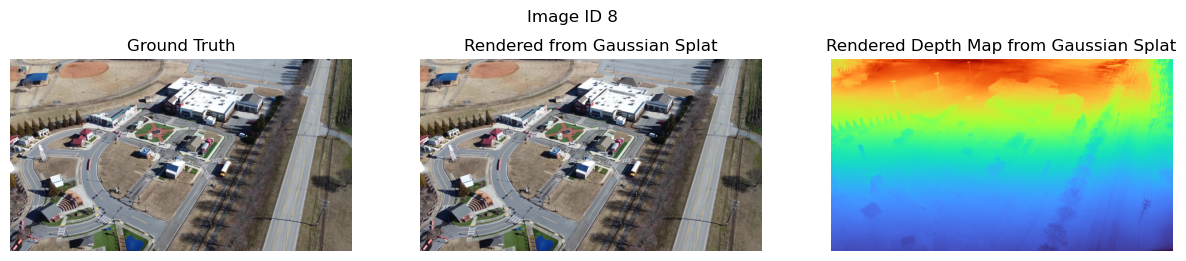

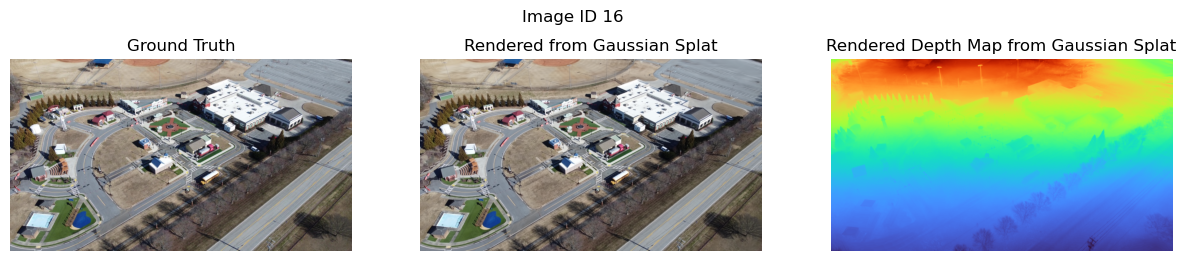

In [8]:
@torch.no_grad()
def plot_reconstruction_results(model: fvdb.GaussianSplat3d, sfm_scene: frc.SfmScene, image_id: int):
    # Get one of the images and its camera from the scene
    image_meta: frc.SfmImageMetadata = sfm_scene.images[image_id]
    camera_meta: frc.SfmCameraMetadata = image_meta.camera_metadata
    camera_to_world_matrix = torch.from_numpy(image_meta.camera_to_world_matrix).to(device=model.device, dtype=torch.float32)
    projection_matrix = torch.from_numpy(camera_meta.projection_matrix).to(device=model.device, dtype=torch.float32)
    image_height, image_width = image_meta.image_size

    # Read the ground truth image from disk
    gt_image = cv2.imread(image_meta.image_path)
    assert gt_image is not None, f"Failed to load image at {image_meta.image_path}"
    gt_image = cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB)

    # Render the image and a depth map from the Gaussian splat model
    rendered_rgbd, alphas = model.render_images_and_depths(
        world_to_camera_matrices=camera_to_world_matrix.inverse().unsqueeze(0).contiguous(),
        projection_matrices=projection_matrix.unsqueeze(0),
        image_width=image_width,
        image_height=image_height,
        near=0.1,
        far=10000.0,
    )
    rgb = rendered_rgbd[0, ..., :3].cpu().numpy()
    depth = (rendered_rgbd[0, ..., 3] / alphas.squeeze()).cpu().numpy()
    rendered_image = np.clip(rgb, 0.0, 1.0)
    rendered_image = (rendered_image * 255).astype(np.uint8)

    # Plot the ground truth and rendered images side by side
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Image ID {image_id}")
    plt.subplot(1, 3, 1)
    plt.title("Ground Truth")
    plt.axis("off")
    plt.imshow(gt_image)
    plt.subplot(1, 3, 2)
    plt.title("Rendered from Gaussian Splat")
    plt.axis("off")
    plt.imshow(rendered_image)
    plt.subplot(1, 3, 3)
    plt.title("Rendered Depth Map from Gaussian Splat")
    plt.axis("off")
    plt.imshow(depth, cmap="turbo")
    plt.show()

model: fvdb.GaussianSplat3d = runner.model
print(f"Reconstructed Gaussian Splat Model has {model.num_gaussians}, is on device {model.device}, and renders images with {model.num_channels} channels.")
plot_reconstruction_results(model, cleaned_sfm_scene, image_id=8)
plot_reconstruction_results(model, cleaned_sfm_scene, image_id=16)


## Export a Gaussian Splat radiance field to PLY and USDZ
You can save Gaussian Splat models to PLY and USDZ files using `fvdb_reality_capture`. This is useful for exporting your Gaussian Splats to be used in other applications, like [SuperSplat](https://superspl.at/editor/), [Blender with the 3DGS Addon](https://github.com/Kiri-Innovation/3dgs-render-blender-addon), or [NVIDIA's Isaac Sim](). Let's see how to do this below.

Try going to [supersplat.at](https://superspl.at/editor/) and dragging the PLY saved below to try it out.

In [9]:
from fvdb_reality_capture.tools import export_splats_to_usdz

# Save the model as a PLY file for viewing in external tools like SuperSplat
model.save_ply("reconstructed_model.ply")

# Save the model as a USDZ file for viewing in tools like NVIDIA's Isaac Sim
export_splats_to_usdz(model, out_path="reconstructed_model.usdz")

2025-10-14 15:55:33,521 - fvdb_reality_capture.tools._export_splats_to_usdz - INFO - Creating USD file containing NuRec model
2025-10-14 15:55:33,579 - fvdb_reality_capture.tools._export_splats_to_usdz - INFO - Model bounding box: min=[-179.34018 -205.18346  -80.47287], max=[163.87242 165.11801  39.01704]
2025-10-14 15:55:33,786 - fvdb_reality_capture.tools._export_splats_to_usdz - INFO - USDZ file created successfully at reconstructed_model.usdz


## Reconstruct a mesh from a Gaussian Splat radiance field

Our Gaussian splat model is capable of producing images and depths from novel views. A natural way to reconstruct a mesh from a Gaussian scene is by rendering depth maps from the camera poses used to reconstruct the model and fuse them into a truncated signed distance field (TSDF) using the TSDF fusion algorithm<sup>[\[2\]](#references)</sup>. 

TSDF fusion accumulates noisy depth maps into a voxel grid, to approximate a signed distance field near the surface of the object. `fvdb_reality_capture` makes use of `fvdb-core` to provide a high performance implementation of TSDF integration on sparse voxels. This allows us to generate meshes from Gaussian splats at very high resolutions on the GPU while using minimal memory.

Let's see how to reconstruct a mesh using the `fvdb_reality_capture.tools` module.


In [10]:
from fvdb_reality_capture.tools import mesh_from_splats
import point_cloud_utils as pcu

# The truncation margin determines the width of the narrow band around the surface in which we compute the TSDF.
# A larger margin will produce coarser voxels, while a smaller margin will produce finer voxels but may miss some surface details.
# Here we pick a truncation margin of 0.25 world units in our scene.
truncation_margin = 0.5

# This function returns a tensor of vertices, faces, and colors for the mesh.
# The vertices have shape (num_vertices, 3), the faces have shape (num_faces, 3),
# and the colors have shape (num_vertices, 3). The colors are in the range [0, 1].
v, f, c = mesh_from_splats(model, cleaned_sfm_scene.camera_to_world_matrices, cleaned_sfm_scene.projection_matrices, cleaned_sfm_scene.image_sizes, truncation_margin)

# Save the mesh as a PLY file for viewing in external tools using point_cloud_utils (https://fwilliams.info/point-cloud-utils/) [3]
pcu.save_mesh_vfc("reconstructed_mesh.ply", v.cpu().numpy(), f.cpu().numpy(), c.cpu().numpy())

print(f"Reconstructed mesh with {v.shape[0]:,} vertices and {f.shape[0]:,} faces")

Extracting TSDF: 100%|██████████| 124/124 [00:07<00:00, 16.34imgs/s, accumulated_voxels=1.49e+8]


Reconstructed mesh with 12,262,862 vertices and 19,518,357 faces


Note how the final voxel count for tsdf fusion was over 140 million! The sparse TSDF fusion in fvdb, can handle large voxel sizes.

If you open the saved mesh in your favorite editor you get something like this:

<div>
<img src="https://fvdb-data.s3.us-east-2.amazonaws.com/fvdb-reality-capture/doc_figures/worse_mesh_recon.png" width="50%"/>
</div>
This looks good from far, but is far from good. The depth maps produced by Gaussian splats are generally pretty noisy. The result is that the TSDF fusion algorithm produces a bumpy surface like the one in the image above. Fortunately, we can do better, by estimating better depth maps from our splats.

`fvdb_reality_capture.tools` provides a `mesh_from_splats_dlnr` which will use a foundation model to compute high quality depth maps from images rendered from our Gaussian splat. 
The method works by rendering stereo pairs from the splat scene, and uses the DLNR foundation model<sup>[\[4\]](#references)</sup> to perform stereo depth estimation. The DLNR model is a high-frequency stereo matching network that computes optical flow and disparity maps between two images
This method is generally slower to run since you have to evaluate a big neural network to estimate depth for each image, but produces much cleaner results.

Let's see how to use this function to do mesh reconstruction:

In [11]:
from fvdb_reality_capture.tools import mesh_from_splats_dlnr
import point_cloud_utils as pcu

# The truncation margin determines the width of the narrow band around the surface in which we compute the TSDF.
# A larger margin will produce coarser voxels, while a smaller margin will produce finer voxels but may miss some surface details.
# Here we pick a truncation margin of 0.25 world units in our scene.
truncation_margin = 0.5

# This function has virtually the same interface as `mesh_from_splats`.
# It returns a tensor of vertices, faces, and colors for the mesh.
# The vertices have shape (num_vertices, 3), the faces have shape (num_faces, 3),
# and the colors have shape (num_vertices, 3). The colors are in the range [0, 1].
v, f, c = mesh_from_splats_dlnr(model, cleaned_sfm_scene.camera_to_world_matrices, cleaned_sfm_scene.projection_matrices, cleaned_sfm_scene.image_sizes, truncation_margin)

# Save the mesh as a PLY file for viewing in external tools using point_cloud_utils (https://fwilliams.info/point-cloud-utils/) [3]
pcu.save_mesh_vfc("reconstructed_mesh_dlnr.ply", v.cpu().numpy(), f.cpu().numpy(), c.cpu().numpy())

print(f"Reconstructed mesh with {v.shape[0]:,} vertices and {f.shape[0]:,} faces")

2025-10-14 15:55:44,221 - fvdb_reality_capture.foundation_models.dlnr.DLNRModel - INFO - Loading DLNR pretrained weights from /home/fwilliams/projects/openvdb/fvdb-reality-capture/fvdb_reality_capture/foundation_models/_weights/middlebury_dlnr.pth
2025-10-14 15:55:44,579 - fvdb_reality_capture.foundation_models.dlnr.DLNRModel - INFO - DLNR model loaded successfully.
Generating DLNR Depths:   0%|          | 0/124 [00:00<?, ?imgs/s]/home/fwilliams/bin/miniconda3/envs/fvdb/lib/python3.12/site-packages/torch/nn/functional.py:5096: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
Extracting TSDF: 100%|██████████| 124/124 [00:07<00:00, 17.70imgs/s, accumulated_voxels=5.8e+7] 


Reconstructed mesh with 8,066,537 vertices and 14,263,418 faces


If you open the saved mesh in your favorite editor, you'll see something like this. Much better! 
Details are preserved, and there isn't much noise in the reconstruction. In general, if you can afford the weight, you should stick to `fvdb_reality_capture.tools.mesh_from_splats_dlnr` for high quality mesh reconstructions.

<div>
<img src="https://fvdb-data.s3.us-east-2.amazonaws.com/fvdb-reality-capture/doc_figures/better_mesh_recon.png" width="50%"/>
</div>

## References
* _\[1\] Kerbl, Kopanas et.al. - ["3D Gaussian Splatting
for Real-Time Radiance Field Rendering"](https://repo-sam.inria.fr/fungraph/3d-gaussian-splatting/)_
* _\[2\] Newcombe et.al. - ["KinectFusion: Real-Time Dense Surface Mapping and Tracking"](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/ismar2011.pdf)_
* _\[3\] Williams - [Point Cloud Utils](https://fwilliams.info/point-cloud-utils/)_
* _\[4\] Zhao, Zhou et.al. - [High Frequency Stereo Matching](https://openaccess.thecvf.com/content/CVPR2023/papers/Zhao_High-Frequency_Stereo_Matching_Network_CVPR_2023_paper.pdf)_